In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from warnings import filterwarnings
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import splitfolders

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchinfo import summary

from sklearn.metrics import classification_report, confusion_matrix

filterwarnings('ignore')

In [3]:
path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
path = pathlib.Path(path)

In [4]:
splitfolders.ratio(path, output='df_splitted', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [08:08, 153.58 files/s]


In [5]:
dir = '/kaggle/working/df_splitted'
dir = pathlib.Path(dir)

In [6]:
transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1),
        transforms.Resize((250, 250))
    ]
)

In [7]:
Train = datasets.ImageFolder(os.path.join(dir, 'train'), transform = transformations)
train_loader = DataLoader(Train, batch_size=32, shuffle=True)
print(f'Train:\n {Train}\n\n')

Test = datasets.ImageFolder(os.path.join(dir, 'test'), transform = transformations)
test_loader = DataLoader(Test, batch_size=32, shuffle=True)
print(f'Test:\n {Test}\n\n')

Validation = datasets.ImageFolder(os.path.join(dir, 'val'), transform = transformations)
validation_loader = DataLoader(Validation, batch_size=32, shuffle=True)
print(f'Validation:\n {Validation}\n\n')

Train:
 Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /kaggle/working/df_splitted/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
           )


Test:
 Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/df_splitted/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
           )


Validation:
 Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/df_splitted/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
           )




In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [10]:
class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dataloader:
            yield to_device(b, self.device)
        
    def __len__(self):
        return len(self.dataloader)
    
    def switch_model_to_cpu(self, model):
        return model.to('cpu')

In [11]:
new_train_dataloader = DeviceDataLoader(train_loader, device)
new_validation_dataloader = DeviceDataLoader(validation_loader, device)

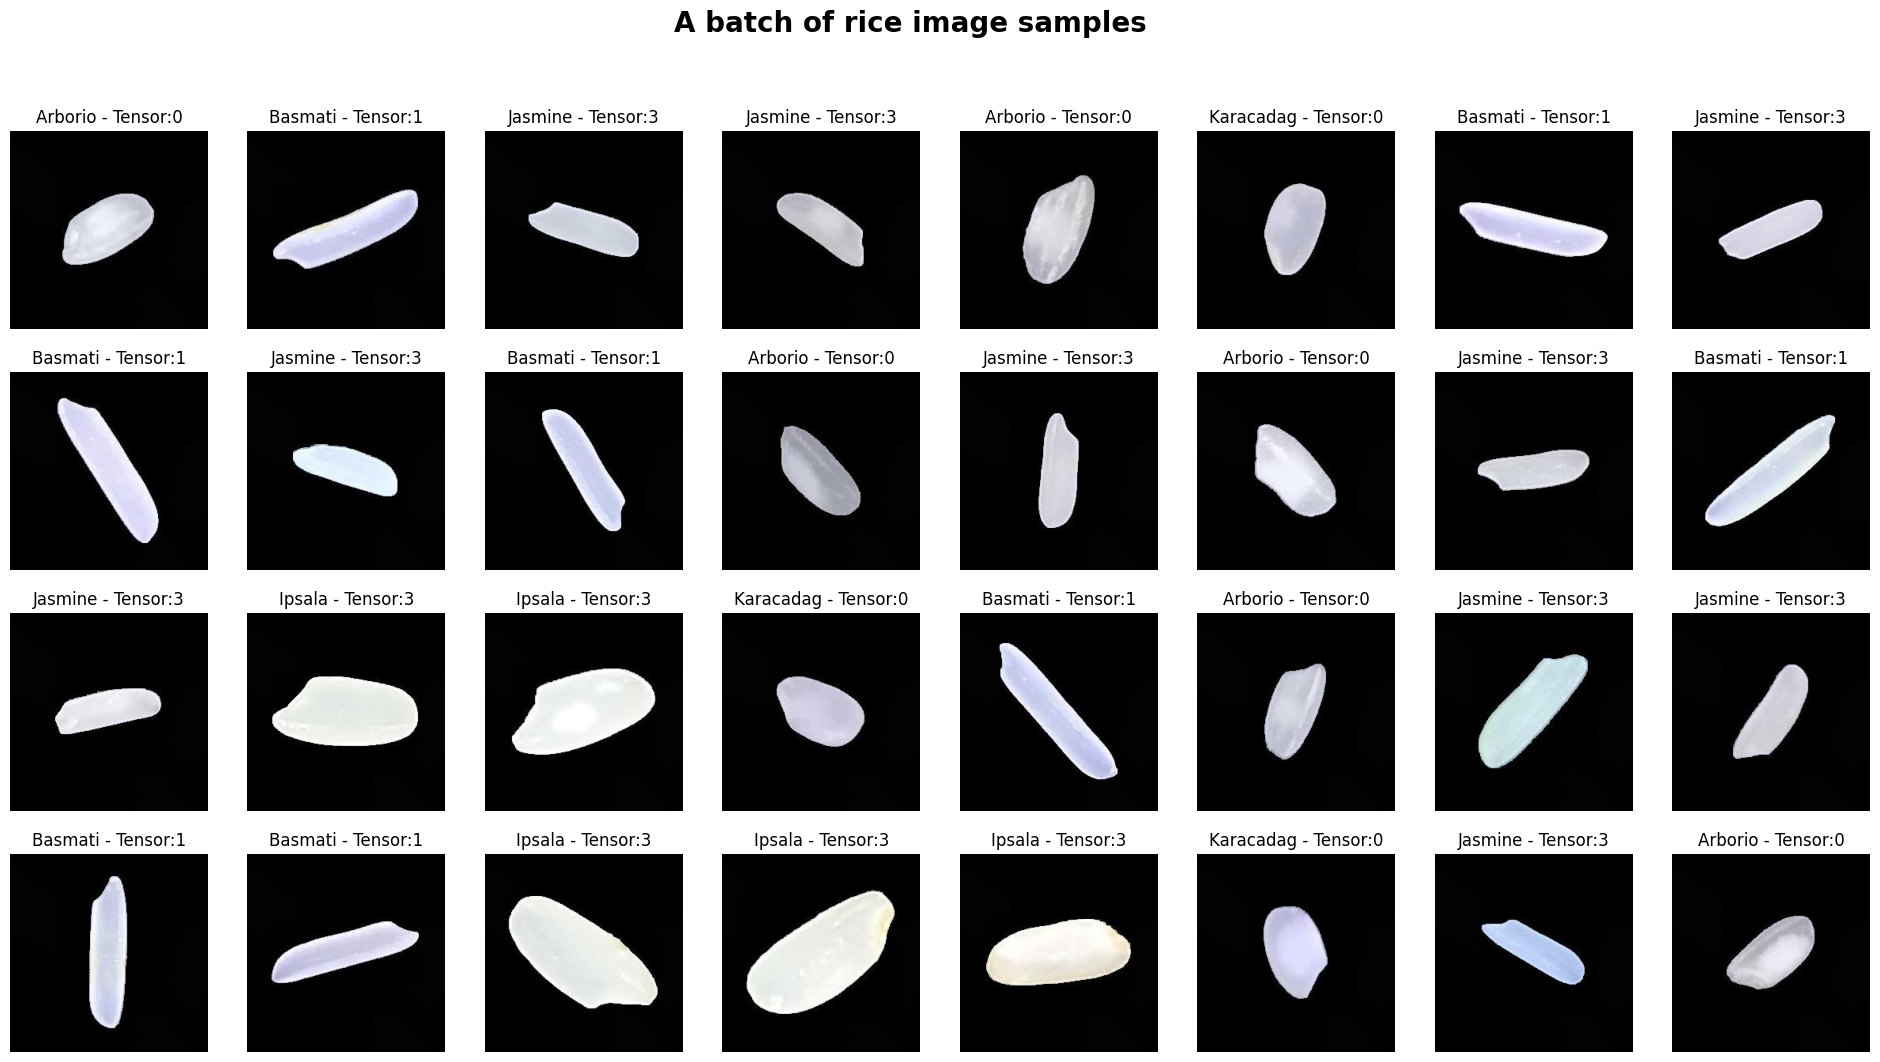

In [12]:
imgs, labels = next(iter(train_loader))
default_labels = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag",
}
img_names = ['image_{}'.format(i) for i in range(len(imgs))]

fig, axes = plt.subplots(4, 8, figsize=(24, 12))
fig.suptitle('A batch of rice image samples', fontsize=20, fontweight='bold')

for ax, img, label_idx, img_name in zip(axes.flatten(), imgs, labels, img_names):
    img = torch.permute(img, (1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'{default_labels[int(label_idx)]} - Tensor:{labels[int(label_idx)]}') 
    ax.axis('off')

plt.show()


In [13]:
class CNN(nn.Module):
    def __init__(self, In_channels, Num_classes):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=In_channels, out_channels=6, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(59536, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, Num_classes)
        )

    def forward(self, x):
        op = self.cnn_layers(x)
        op = torch.flatten(op, 1)
        op = self.dense_layers(op)
        return op

In [14]:
model = to_device(CNN(3, len(Train.classes)), device)
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       168
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       880
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       7,144,440
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       10,164
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      425
Total params: 7,156,077
Trainable params: 7,156,077
Non-trainable params: 0

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    
    # Train
    model.train()
    train_loss = []
    correct_train = 0
    total_train = 0
    
    for images, labels in new_train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = np.mean(train_loss)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = []
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in new_validation_dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = np.mean(val_loss)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} : Train Loss:{train_loss:.4f}, Train Acc:{train_acc:.4f}, Val Loss:{val_loss:.4f}, Val Acc:{val_acc:.4f}')


Epoch 1/5 : Train Loss:0.1456, Train Acc:0.9486, Val Loss:0.0969, Val Acc:0.9644
Epoch 2/5 : Train Loss:0.0880, Train Acc:0.9703, Val Loss:0.0938, Val Acc:0.9683
Epoch 3/5 : Train Loss:0.0755, Train Acc:0.9739, Val Loss:0.0800, Val Acc:0.9740
Epoch 4/5 : Train Loss:0.0605, Train Acc:0.9783, Val Loss:0.0564, Val Acc:0.9826
Epoch 5/5 : Train Loss:0.0407, Train Acc:0.9859, Val Loss:0.0437, Val Acc:0.9852


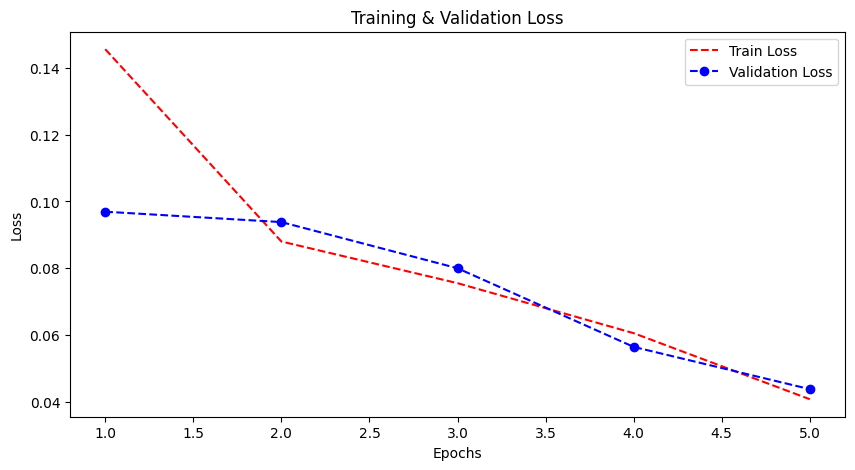

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, 'r--', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, '--bo', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

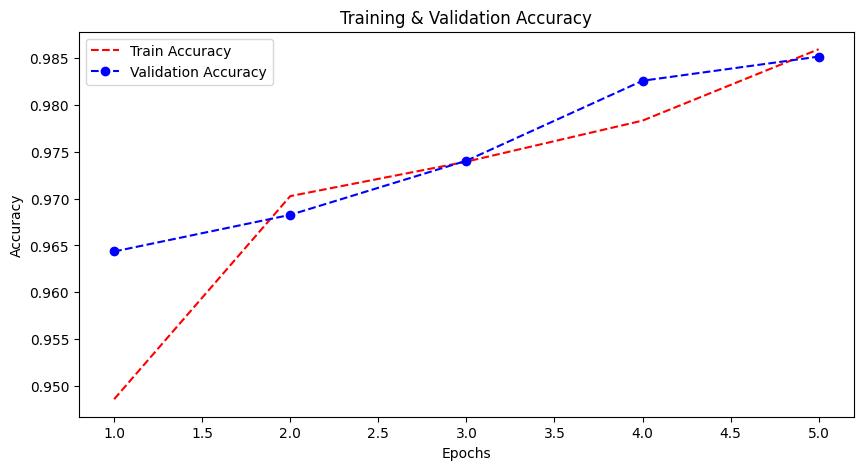

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, 'r--', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, '--bo',  label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

In [18]:
new_test_dataloader = DeviceDataLoader(test_loader, device)

In [19]:
with torch.no_grad() :
    model.eval()
    test_loss = []
    correct_test = 0
    total_test = 0

    for images, labels in new_test_dataloader :

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())

        _, prediction = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (prediction==labels).sum().item()
        
    test_loss = np.mean(test_loss)
    test_acc = correct_test / total_test
    
    print(f'Test loss: {test_loss:.4f}\nTest Accuracy: {test_acc:.4f}')

Test loss: 0.0410
Test Accuracy: 0.9865


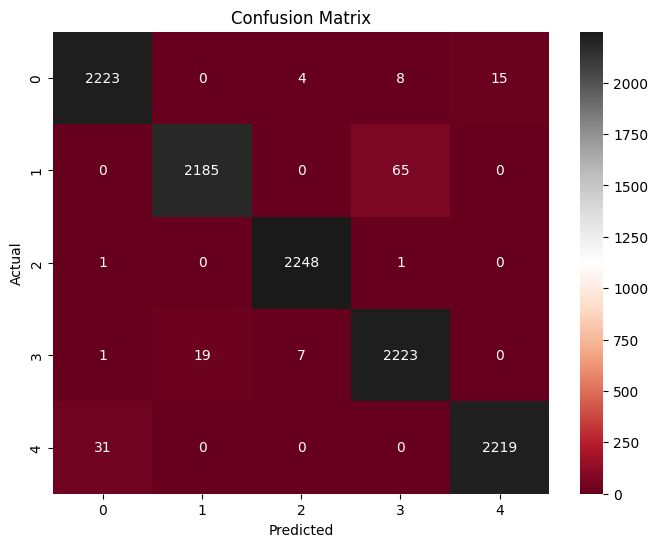

Classification Report:
               precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      2250
     Basmati       0.99      0.97      0.98      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.97      0.99      0.98      2250
   Karacadag       0.99      0.99      0.99      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



In [20]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in new_test_dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdGy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(all_labels, all_preds, target_names=Test.classes)
print("Classification Report:\n", report)
